In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.random_projection import GaussianRandomProjection

from pandas.api.types import is_string_dtype
from pandas.api.types import is_categorical_dtype

In [30]:
import scipy.sparse as sps
from scipy.linalg import pinv
import numpy as np

def reconstruction(projections,X):
    W = projections.components_
    if sps.issparse(W):
        W = W.todense()
    p = pinv(W)
    reconstructed = ((p@W)@(X.T)).T # Unproject projected data
    errors = np.square(X-reconstructed)
    return np.nanmean(errors)

In [31]:
def pre_processing(credit):
	# preprocessing - convert data type and dummy coding
	cols = credit.columns
	isCat_Index = list()
	for col in cols:
		if is_string_dtype(credit[col]):
			credit[col] = credit[col].astype('category')
		isCat_Index.append(is_categorical_dtype(credit[col]))
	
	credit_d = pd.get_dummies(credit, columns=list(cols[isCat_Index]))
	print(credit_d.shape)
	return credit_d

In [32]:
SEED = 166

# preprocessing: scaling the data and split dataset
data = pd.read_csv("../credit.csv")
data = pre_processing(data)
predictors = data[data.columns.difference(["default"])]
scaler = MinMaxScaler()
predictors_scaled = scaler.fit_transform(predictors)
target = data[["default"]].values.ravel()

train_X, test_X, train_y, test_y = train_test_split(predictors_scaled, target, train_size=0.8, random_state=SEED, stratify=target)

# in clustering experiments, only use training set
data, label = train_X, train_y

(1000, 62)


In [33]:
def random_project():
    reconstructionErrors = []
    maxComponents = 62
    minComponents = 1
    for i in range(minComponents, maxComponents):
        rca = GaussianRandomProjection(n_components=i)
        rca.fit(data)
        reconstructionErrors.append(reconstruction(rca, data))
        # print diagnostics
        #print('Components \n', projection.components_)
#         print('Number of Components ',projection.n_components_)
#         print('Reconstruction Error ',reconstructionError(projection,data))
    return reconstructionErrors

          0         1         2         3         4         5         6  \
0  0.236938  0.234706  0.225914  0.218943  0.210978  0.218717  0.211627   
1  0.236618  0.226773  0.224618  0.208837  0.213639  0.197888  0.207770   
2  0.235303  0.225429  0.229223  0.229348  0.210604  0.224253  0.207673   
3  0.236365  0.229800  0.223500  0.228270  0.209142  0.208592  0.210994   
4  0.236642  0.234042  0.229661  0.225587  0.221907  0.212588  0.215348   

          7         8         9  ...        52        53        54        55  \
0  0.212829  0.190222  0.201323  ...  0.021340  0.023833  0.027027  0.015832   
1  0.200245  0.212292  0.202195  ...  0.034327  0.039739  0.024547  0.020523   
2  0.199614  0.196967  0.185419  ...  0.027870  0.031519  0.019048  0.044901   
3  0.200245  0.204133  0.196740  ...  0.033343  0.024981  0.030132  0.018377   
4  0.205244  0.204288  0.204943  ...  0.032048  0.025948  0.026759  0.037326   

         56        57        58        59            60             

<ipython-input-38-3617b2c3fe73>:15: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.plot(df1.mean(axis=0), label='mean', color='r', linewidth=3)


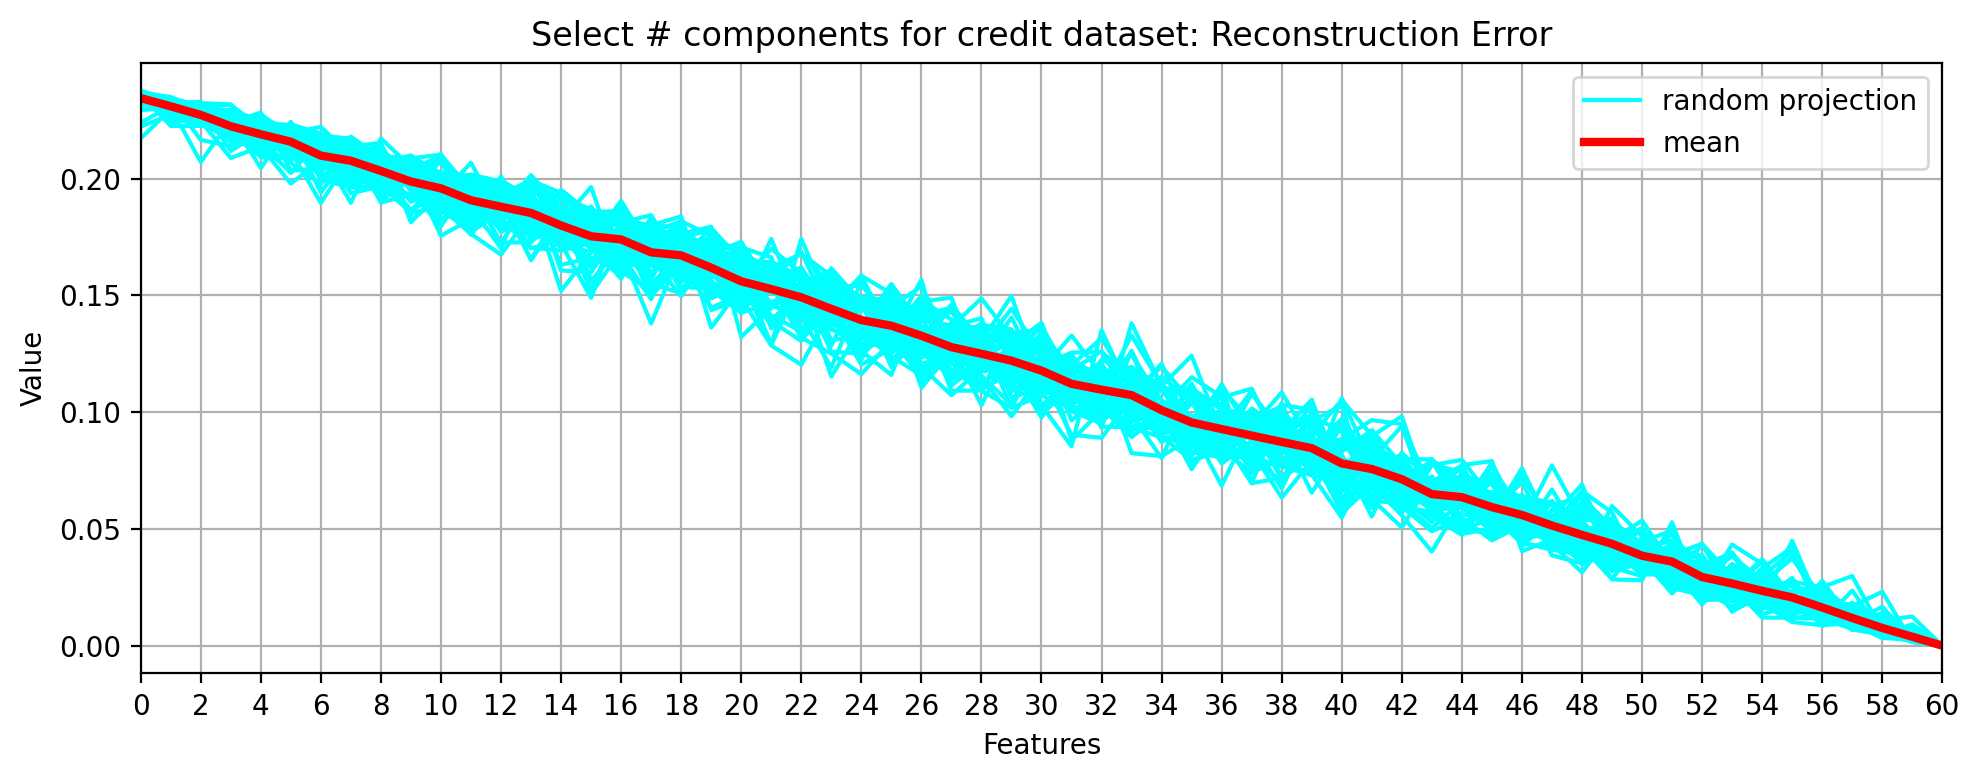

In [38]:
from matplotlib.pyplot import MultipleLocator

errors = []
for _ in range(50):
    tmp = random_project()
    errors.append(tmp)

df1 = pd.DataFrame(errors)
# df1['diagnosis'] = y1
df1['class'] = "random projection"
print(df1.head(5))

plt.figure(figsize=(10, 4), dpi=200)
pd.plotting.parallel_coordinates(df1,'class', colormap='cool', axvlines=False)
plt.plot(df1.mean(axis=0), label='mean', color='r', linewidth=3)
# plt.plot(df1.std(axis=0), label='std', color='g', linewidth=3)
# plt.xticks(rotation=30)
x_major_locator=MultipleLocator(2)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xlabel('Features')
plt.ylabel('Value')
plt.legend(loc='best')
plt.title('Select # components for credit dataset: Reconstruction Error')
plt.tight_layout()
plt.savefig(r'C:\Users\Yiwei Zhang\Desktop\plots\rca_credit_error.png', dpi=300)

<ipython-input-47-28fdee13eac3>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.plot(df1.std(axis=0), label='std', color='g', linewidth=1)


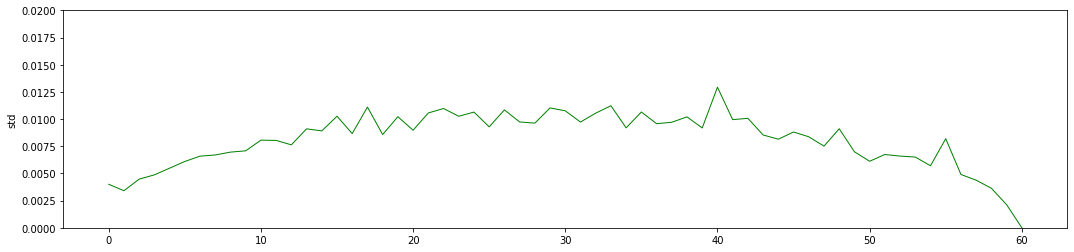

In [47]:
plt.figure(figsize=(18,4))
plt.plot(df1.std(axis=0), label='std', color='g', linewidth=1)
plt.ylim(0, 0.02)
plt.ylabel("std")
plt.show()

(1000, 62)
Misclassified samples: 55
SVM Kernel train/test accuracy: 0.795/0.725


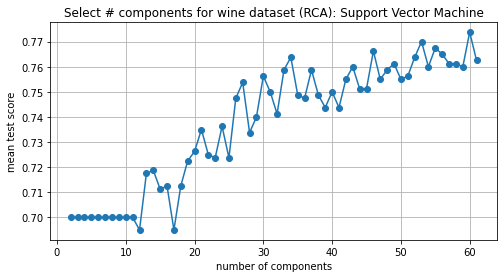

In [20]:
from sklearn.random_projection import GaussianRandomProjection
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

######
# Run Grid Search to find optimal components
######
# import packages
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

SEED = 77
# preprocessing: scaling the data and split dataset
data = pd.read_csv("../credit.csv")
data = pre_processing(data)
predictors = data[data.columns.difference(["default"])]

target = data[["default"]].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(predictors, target, train_size=0.8, random_state=SEED, stratify=target)
# Scale the data
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
X_toTransform = X_train_std
y_train = y_train
y_test = y_test

# Define the classifier
svm = SVC(random_state=1, kernel='linear', gamma=0.1, C=10)
pipe = Pipeline([
    ('reduce_dim', GaussianRandomProjection())
     ,('classify', svm)
])
N_FEATURES_OPTIONS = range(2,62)
parameters = {  'reduce_dim__n_components':N_FEATURES_OPTIONS,
             }
clf = GridSearchCV(pipe, cv=5, param_grid=parameters, n_jobs=-1)

# Run the classifier
clf.fit(X_train_std, y_train)

# Identify training and test accuracy
y_pred = clf.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
y_pred_train = clf.predict(X_train_std)
y_pred_test = clf.predict(X_test_std)
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print('SVM Kernel train/test accuracy: %.3f/%.3f' % (train_accuracy, test_accuracy))

mean_scores = np.array(clf.cv_results_['mean_test_score'])

mean_scores = mean_scores.max(axis=0)
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (1 + 1) + .5)

scores = [x for x in clf.cv_results_['mean_test_score']]

plt.figure(figsize=(8,4))
plt.plot(N_FEATURES_OPTIONS, scores,'-o')
# plt.xticks(k_grid)
plt.xlabel('number of components')
plt.ylabel('mean test score')
plt.title('Select # components for wine dataset (RCA): Support Vector Machine')
plt.grid()
plt.savefig(r'C:\Users\Yiwei Zhang\Desktop\plots\rca_credit_svm.png', dpi=300)
plt.show()